1. Score matching - load M13 scores and features from sunburst and run them through M13 and check for score match. Note model 11 features were matched with model 13 scores since m13 payload isn't persisted. 
2. Distribution analysis wrt Edgar - compare distributions (features, scores, etc.) for sb transitioned edgars between sb and legacy


In [1]:
import os 
import pandas as pd
import snowflake.connector
import xgboost as xgb
import numpy as np

In [2]:

query = """
WITH score_report_unique AS (
    SELECT *
    FROM BRZ_CLKAPP.RISKDATA.tb_risk_model_score_report
    WHERE RESOURCE = 'MODEL_13' 
    QUALIFY ROW_NUMBER() OVER (
        PARTITION BY APPLICATION_KEY, ROSE_UNIQUE_KEY 
        ORDER BY SRC_TRANSACTION_TIME DESC
    ) = 1
),
score_transaction_unique AS (
    SELECT *
    FROM BRZ_CLKAPP.RISKDATA.tb_risk_model_score_transaction
    WHERE RESOURCE = 'MODEL_11' -- Use model 11 features since model 13 features aren't persisted
    QUALIFY ROW_NUMBER() OVER (
        PARTITION BY APPLICATION_KEY, ROSE_UNIQUE_KEY 
        ORDER BY SRC_TRANSACTION_TIME DESC
    ) = 1
)

SELECT 
    r.APPLICATION_KEY, 
    r.ROSE_UNIQUE_KEY, 
    r.src_transaction_time,
    TRY_PARSE_JSON(r.CACHE):assessment.score::FLOAT AS score,
    t.ADDITIONAL_INFORMATION,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."vendor_equipment_type"::STRING AS vendor_equipment_type,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."experian_experianRiskModel_RC"::INT AS experian_experianRiskModel_RC,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."experian_experianRiskModel_V3"::INT AS experian_experianRiskModel_V3,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."experian_experianProfileSummary_derogCounter"::INT AS experian_experianProfileSummary_derogCounter,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."coreLogic_coreLogicInquiryReport_corelIdScore"::INT AS coreLogic_coreLogicInquiryReport_corelIdScore,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."experian_experianProfileSummary_pastDueAmount"::INT AS experian_experianProfileSummary_pastDueAmount,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."coreLogic_coreLogicApplicantVariable_TTRecinqm"::INT AS coreLogic_coreLogicApplicantVariable_TTRecinqm,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."experian_experianProfileSummary_monthlyPayment"::INT AS experian_experianProfileSummary_monthlyPayment,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."coreLogic_coreLogicApplicantVariable_TTInqall00"::INT AS coreLogic_coreLogicApplicantVariable_TTInqall00,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."experian_experianProfileSummary_thirtyDayCounter"::INT AS experian_experianProfileSummary_thirtyDayCounter,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."experian_experianProfileSummary_installmentBalance"::INT AS experian_experianProfileSummary_installmentBalance,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."experian_experianProfileSummary_paidAccountsCounter"::INT AS experian_experianProfileSummary_paidAccountsCounter,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."experian_experianProfileSummary_ninetyPlusDayCounter"::INT AS experian_experianProfileSummary_ninetyPlusDayCounter,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."experian_experianProfileSummary_totalInquiriesCounter"::INT AS experian_experianProfileSummary_totalInquiriesCounter,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."experian_experianProfileSummary_totalRevolvingBalance"::INT AS experian_experianProfileSummary_totalRevolvingBalance,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."experian_experianProfileSummary_totalTradeItemsCounter"::INT AS experian_experianProfileSummary_totalTradeItemsCounter,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."experian_experianProfileSummary_wasDelinquentDerogCounter"::INT AS experian_experianProfileSummary_wasDelinquentDerogCounter,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."experian_experianProfileSummary_totalRevolvingAvailablePercent"::INT AS experian_experianProfileSummary_totalRevolvingAvailablePercent,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."experian_experianProfileSummary_inquiriesDuringLastSixMonthsCounter"::INT AS experian_experianProfileSummary_inquiriesDuringLastSixMonthsCounter,
    PARSE_JSON(t.ADDITIONAL_INFORMATION):originalRequest."datax_dataxReport_idaScore"::INT AS datax_dataxReport_idaScore
    
FROM score_report_unique r
LEFT JOIN score_transaction_unique t
  ON r.APPLICATION_KEY = t.APPLICATION_KEY
  AND r.ROSE_UNIQUE_KEY = t.ROSE_UNIQUE_KEY;
"""

conn = snowflake.connector.connect(
                account = 'byb44065.us-east-1',
                user = os.getenv('SNOWFLAKE_USERNAME'),
                password = os.getenv('SNOWFLAKE_PASSWORD'),
                database = 'BRZ_CLKAPP',
                schema = 'DBO',
                warehouse = 'WH_DATA_SCIENTISTS'
            )
df_sf = pd.read_sql(query, conn)
conn.close()

print(df_sf.shape)


/tmp/ipykernel_3298831/338289384.py:62: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sf = pd.read_sql(query, conn)


(511, 25)


In [3]:
df = df_sf.copy()

In [4]:
# How many scores have a value of 1?
df[df['SCORE']==1].shape

(8, 25)

In [5]:
# Could the corelogic features be a reason for mistmatches? 
# df.loc[df['CORELOGIC_CORELOGICAPPLICANTVARIABLE_TTINQALL00']==0,'CORELOGIC_CORELOGICAPPLICANTVARIABLE_TTINQALL00'] = np.nan
# df.loc[df['CORELOGIC_CORELOGICAPPLICANTVARIABLE_TTRECINQM']==0,'CORELOGIC_CORELOGICAPPLICANTVARIABLE_TTRECINQM'] = np.nan

In [6]:
# Set experian features to null to confirm hypothesis of missing experian features
for col in [col for col in df.columns if col.startswith('EXPER')]:
    df[col] = np.nan

In [7]:
# Align feature names 
train_names = ['experian_experianProfileSummary_installmentBalance',
       'experian_experianProfileSummary_totalRevolvingBalance',
       'experian_experianProfileSummary_totalRevolvingAvailablePercent',
       'experian_experianProfileSummary_pastDueAmount',
       'experian_experianProfileSummary_monthlyPayment',
       'experian_experianProfileSummary_inquiriesDuringLastSixMonthsCounter',
       'experian_experianProfileSummary_totalInquiriesCounter',
       'experian_experianProfileSummary_totalTradeItemsCounter',
       'experian_experianProfileSummary_paidAccountsCounter',
       'experian_experianProfileSummary_wasDelinquentDerogCounter',
       'experian_experianProfileSummary_thirtyDayCounter',
       'experian_experianProfileSummary_ninetyPlusDayCounter',
       'experian_experianProfileSummary_derogCounter',
       'experian_experianRiskModel_V3', 
       'experian_experianRiskModel_RC',
       'datax_dataxReport_idaScore',
       'coreLogic_coreLogicInquiryReport_corelIdScore',
       'coreLogic_coreLogicApplicantVariable_TTInqall00',
       'coreLogic_coreLogicApplicantVariable_TTRecinqm', 
       'vendor_equipment_type']

prod_names = [
       'EXPERIAN_EXPERIANPROFILESUMMARY_INSTALLMENTBALANCE',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALREVOLVINGBALANCE',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALREVOLVINGAVAILABLEPERCENT',
       'EXPERIAN_EXPERIANPROFILESUMMARY_PASTDUEAMOUNT',
       'EXPERIAN_EXPERIANPROFILESUMMARY_MONTHLYPAYMENT',
       'EXPERIAN_EXPERIANPROFILESUMMARY_INQUIRIESDURINGLASTSIXMONTHSCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALINQUIRIESCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_TOTALTRADEITEMSCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_PAIDACCOUNTSCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_WASDELINQUENTDEROGCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_THIRTYDAYCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_NINETYPLUSDAYCOUNTER',
       'EXPERIAN_EXPERIANPROFILESUMMARY_DEROGCOUNTER',
       'EXPERIAN_EXPERIANRISKMODEL_V3',
       'EXPERIAN_EXPERIANRISKMODEL_RC', 
       'DATAX_DATAXREPORT_IDASCORE',
       'CORELOGIC_CORELOGICINQUIRYREPORT_CORELIDSCORE',
       'CORELOGIC_CORELOGICAPPLICANTVARIABLE_TTINQALL00',
       'CORELOGIC_CORELOGICAPPLICANTVARIABLE_TTRECINQM',
       'VENDOR_EQUIPMENT_TYPE',
       ]

# dict(zip(prod_names, train_names))
df = df.rename(dict(zip(prod_names, train_names)), axis=1)


In [8]:
# Process features 

df.loc[df['coreLogic_coreLogicInquiryReport_corelIdScore'] == 999, 'coreLogic_coreLogicInquiryReport_corelIdScore'] = -99
df['rc_9105_flag'] = df['experian_experianRiskModel_RC'].apply(lambda x: 1 if x == 9105 else 0)
df.loc[df['experian_experianRiskModel_RC'] == 9105, 'experian_experianRiskModel_RC'] = -99

cond = (df['experian_experianRiskModel_V3'] != -99) & (~df['experian_experianRiskModel_V3'].between(300, 850))
df.loc[cond, 'experian_experianRiskModel_V3'] = 500

equipment_types = ['Trailers', 'Industrial', 'Food Service', 'Construction/Landscaping', 'Automotive', 'Janitorial/Remediation','Food Truck', 'DTG/Embroidery', 'Entertainment/Amusement', 'Photo-A/V', 'Rental', 'Office/Printing']  
def set_equipment_group_new(vendor_class):
    if vendor_class in equipment_types:
        return vendor_class
    else:
        return 'Other'
      
df['vendor_classification_new'] = df['vendor_equipment_type'].apply(set_equipment_group_new).astype('category')
# df = df.drop(['vendor_equipment_type'], axis=1)

dummy_columns = ["equipment_type_Automotive",
                    "equipment_type_Construction/Landscaping",
                    "equipment_type_DTG/Embroidery",
                    "equipment_type_Entertainment/Amusement",
                    "equipment_type_Food Service",
                    "equipment_type_Food Truck",
                    "equipment_type_Industrial",
                    "equipment_type_Janitorial/Remediation",
                    "equipment_type_Office/Printing",
                    "equipment_type_Other",
                    "equipment_type_Photo-A/V",
                    "equipment_type_Rental",
                    "equipment_type_Trailers"]

dummies = pd.get_dummies(df['vendor_classification_new'], prefix='equipment_type', dtype=int)
dummies = dummies.reindex(columns=dummy_columns, fill_value=0)
df = pd.concat([df, dummies], axis=1)
# df = df.drop(['vendor_classification_new'], axis=1)

# df = df.drop(['ID', 'APPLICATION_ID', 'CREATED_TS', 'STATUS'], axis=1)


In [9]:
# Load model and predict
model_path = '../data/model_11_2_3.json'

loaded_model = xgb.Booster()
loaded_model.load_model(model_path)

X = df[loaded_model.feature_names]
X = X.fillna(-99) # fill all features with -99

dtest = xgb.DMatrix(X, missing=-99)

df['y_pred'] = loaded_model.predict(dtest)


In [10]:
#
print('total rows:')
print(len(df))
# Print number of 
print("Number of scores that are off:")
print(len(df[(abs(df['SCORE']-df['y_pred']) > .000001)&(df['SCORE']!= 1)]))

total rows:
511
Number of scores that are off:
16


In [11]:
# Explore scores that are off
# What industry do they come from 
df[(abs(df['SCORE']-df['y_pred']) > .000001)&(df['SCORE']!= 1)]['vendor_classification_new'].value_counts()
# df['vendor_equipment_type'].value_counts()
# df['vendor_classification_new'].value_counts()


vendor_classification_new
Trailers                    5
Industrial                  4
Food Service                3
Other                       1
Construction/Landscaping    1
Automotive                  1
Office/Printing             1
DTG/Embroidery              0
Entertainment/Amusement     0
Janitorial/Remediation      0
Photo-A/V                   0
Name: count, dtype: int64

In [12]:
# Order by largest score differece 
df['score_diff_abs'] = abs(df['SCORE']-df['y_pred'])
pd.set_option('display.max_columns', 500)

df[(abs(df['SCORE']-df['y_pred']) > .000001)&(df['SCORE']!= 1)][['SCORE', 'y_pred']+list(df.columns)].sort_values('score_diff_abs', ascending=False )

,SCORE,y_pred,APPLICATION_KEY,ROSE_UNIQUE_KEY,SRC_TRANSACTION_TIME,SCORE,ADDITIONAL_INFORMATION,vendor_equipment_type,experian_experianRiskModel_RC,experian_experianRiskModel_V3,experian_experianProfileSummary_derogCounter,coreLogic_coreLogicInquiryReport_corelIdScore,experian_experianProfileSummary_pastDueAmount,coreLogic_coreLogicApplicantVariable_TTRecinqm,experian_experianProfileSummary_monthlyPayment,coreLogic_coreLogicApplicantVariable_TTInqall00,experian_experianProfileSummary_thirtyDayCounter,experian_experianProfileSummary_installmentBalance,experian_experianProfileSummary_paidAccountsCounter,experian_experianProfileSummary_ninetyPlusDayCounter,experian_experianProfileSummary_totalInquiriesCounter,experian_experianProfileSummary_totalRevolvingBalance,experian_experianProfileSummary_totalTradeItemsCounter,experian_experianProfileSummary_wasDelinquentDerogCounter,experian_experianProfileSummary_totalRevolvingAvailablePercent,experian_experianProfileSummary_inquiriesDuringLastSixMonthsCounter,datax_dataxReport_idaScore,rc_9105_flag,vendor_classification_new,equipment_type_Automotive,equipment_type_Construction/Landscaping,equipment_type_DTG/Embroidery,equipment_type_Entertainment/Amusement,equipment_type_Food Service,equipment_type_Food Truck,equipment_type_Industrial,equipment_type_Janitorial/Remediation,equipment_type_Office/Printing,equipment_type_Other,equipment_type_Photo-A/V,equipment_type_Rental,equipment_type_Trailers,y_pred,score_diff_abs
248,0.334080,0.123193,793c7a8a-c72b-4309-866d-206976e12d06,5ce13e6b-d9db-403b-a6c5-44ea7764decc,2025-03-24 21:20:37.566435,0.334080,"{""modelId"": 11, ""originalRequest"": {""vendor_eq...",Food Service,NaN,500.0,NaN,334.0,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,642.0,0,Food Service,0,0,0,0,1,0,0,0,0,0,0,0,0,0.123193,0.210887
497,0.290380,0.138357,bbcc8251-0d68-459f-92c3-9f82ae74dfa9,1262efc1-39b8-4cdf-9750-03cd2ec5cb6c,2025-03-25 21:56:03.900500,0.290380,"{""modelId"": 11, ""originalRequest"": {""vendor_eq...",Medical,NaN,500.0,NaN,401.0,NaN,0.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,577.0,0,Other,0,0,0,0,0,0,0,0,0,1,0,0,0,0.138357,0.152022
315,0.119876,0.158709,6e529b0b-add5-4688-b8d6-1305fd95bcbe,686db447-5bc1-4691-b972-c44b6e067a6a,2025-03-27 14:31:59.676510,0.119876,"{""modelId"": 11, ""originalRequest"": {""vendor_eq...",Automotive,NaN,500.0,NaN,NaN,NaN,1.0,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,556.0,0,Automotive,1,0,0,0,0,0,0,0,0,0,0,0,0,0.158709,0.038833
239,0.110232,0.142779,071f7e80-0ba4-4951-942e-b582f6e1ac9d,4d58bf58-a1fb-4b8b-8d2e-4f85de687e02,2025-03-27 01:33:54.588780,0.110232,"{""modelId"": 11, ""originalRequest"": {""vendor_eq...",Industrial,NaN,500.0,NaN,NaN,NaN,28.0,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,539.0,0,Industrial,0,0,0,0,0,0,1,0,0,0,0,0,0,0.142779,0.032547
291,0.108760,0.123199,15e160ea-7fa1-4cdb-ae5d-d9fa2049313f,47927c06-ace4-4244-80d1-474f9ca9b975,2025-03-14 04:12:44.225767,0.108760,"{""modelId"": 11, ""originalRequest"": {""vendor_eq...",Industrial,NaN,500.0,NaN,NaN,NaN,30.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,421.0,0,Industrial,0,0,0,0,0,0,1,0,0,0,0,0,0,0.123199,0.014439
292,0.148613,0.153836,dcea3171-315b-4280-8e3c-b62d8d7abd38,1b60acaa-b0ee-4096-b2ea-b0a5329f1a1d,2025-03-16 22:51:50.992737,0.148613,"{""modelId"": 11, ""originalRequest"": {""vendor_eq...",Construction/Landscaping,NaN,500.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,450.0,0,Construction/Landscaping,0,1,0,0,0,0,0,0,0,0,0,0,0,0.153836,0.005223
156,0.136716,0.131666,b2582088-30d2-4a15-8408-1ccf4713ed73,ed56c63f-d95b-44a4-9122-2f27626ea929,2025-03-22 22:53:16.687278,0.136716,"{""modelId"": 11, ""originalRequest"": {""vendor_eq...",Food Service,NaN,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Food Service,0,0,0,0,1,0,0,0,0,0,0,0,0,0.131666,0.005050
24,0.137840,0.142747,fa68b22a-cd47-4d10-9202-474294b10a32,87bd5f8f-36bc-49de-ba26-b8784c1e3168,2025-03-18 15:53:34.520288,0.13784

In [ ]:
# Compare feature distributions between correct and mismatched score groups 
df[(abs(df['SCORE']-df['y_pred']) > .000001)&(df['SCORE']!= 1)][['SCORE', 'y_pred']+list(df.columns)].describe()

,SCORE,y_pred,SCORE,experian_experianRiskModel_RC,experian_experianRiskModel_V3,experian_experianProfileSummary_derogCounter,coreLogic_coreLogicInquiryReport_corelIdScore,experian_experianProfileSummary_pastDueAmount,coreLogic_coreLogicApplicantVariable_TTRecinqm,experian_experianProfileSummary_monthlyPayment,coreLogic_coreLogicApplicantVariable_TTInqall00,experian_experianProfileSummary_thirtyDayCounter,experian_experianProfileSummary_installmentBalance,experian_experianProfileSummary_paidAccountsCounter,experian_experianProfileSummary_ninetyPlusDayCounter,experian_experianProfileSummary_totalInquiriesCounter,experian_experianProfileSummary_totalRevolvingBalance,experian_experianProfileSummary_totalTradeItemsCounter,experian_experianProfileSummary_wasDelinquentDerogCounter,experian_experianProfileSummary_totalRevolvingAvailablePercent,experian_experianProfileSummary_inquiriesDuringLastSixMonthsCounter,datax_dataxReport_idaScore,rc_9105_flag,equipment_type_Automotive,equipment_type_Construction/Landscaping,equipment_type_DTG/Embroidery,equipment_type_Entertainment/Amusement,equipment_type_Food Service,equipment_type_Food Truck,equipment_type_Industrial,equipment_type_Janitorial/Remediation,equipment_type_Office/Printing,equipment_type_Other,equipment_type_Photo-A/V,equipment_type_Rental,equipment_type_Trailers,y_pred,score_diff_abs
count,16.000000,16.000000,16.000000,0.0,16.0,0.0,3.000000,0.0,15.000000,0.0,15.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.000000,16.0,16.0000,16.0000,16.0,16.0,16.000000,16.0,16.000000,16.0,16.0000,16.0000,16.0,16.0,16.000000,16.000000,16.000000
mean,0.158167,0.142452,0.158167,NaN,500.0,NaN,427.666667,NaN,7.666667,NaN,3.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,523.428571,0.0,0.0625,0.0625,0.0,0.0,0.187500,0.0,0.250000,0.0,0.0625,0.0625,0.0,0.0,0.312500,0.142452,0.031267
std,0.066913,0.025908,0.066913,NaN,0.0,NaN,109.463845,NaN,16.303666,NaN,6.696125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.240987,0.0,0.2500,0.2500,0.0,0.0,0.403113,0.0,0.447214,0.0,0.2500,0.2500,0.0,0.0,0.478714,0.025908,0.060532
min,0.106413,0.110345,0.106413,NaN,500.0,NaN,334.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,421.000000,0.0,0.0000,0.0000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.000000,0.110345,0.003558
25%,0.119444,0.129549,0.119444,NaN,500.0,NaN,367.500000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.000000,0.0,0.0000,0.0000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.000000,0.129549,0.004908
50%,0.137840,0.142747,0.137840,NaN,500.0,NaN,401.000000,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,502.000000,0.0,0.0000,0.0000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.000000,0.142747,0.004908
75%,0.140533,0.142755,0.140533,NaN,500.0,NaN,474.500000,NaN,1.000000,NaN,2.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,551.750000,0.0,0.0000,0.0000,0.0,0.0,0.000000,0.0,0.250000,0.0,0.0000,0.0000,0.0,0.0,1.000000,0.142755,0.018966
max,0.334080,0.226071,0.334080,NaN,500.0,NaN,548.000000,NaN,54.000000,NaN,22.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,642.000000,0.0,1.0000,1.0000,0.0,0.0,1.000000,0.0,1.000000,0.0,1.0000,1.0000,0.0,0.0,1.000000,0.226071,0.210887


In [14]:
# df[df['SCORE']==df['y_pred']][['SCORE', 'y_pred', 'experian_experianRiskModel_RC', 'coreLogic_coreLogicApplicantVariable_TTRecinqm', 'coreLogic_coreLogicApplicantVariable_TTInqall00']]
df[df['SCORE']==df['y_pred']].describe()


,SCORE,experian_experianRiskModel_RC,experian_experianRiskModel_V3,experian_experianProfileSummary_derogCounter,coreLogic_coreLogicInquiryReport_corelIdScore,experian_experianProfileSummary_pastDueAmount,coreLogic_coreLogicApplicantVariable_TTRecinqm,experian_experianProfileSummary_monthlyPayment,coreLogic_coreLogicApplicantVariable_TTInqall00,experian_experianProfileSummary_thirtyDayCounter,experian_experianProfileSummary_installmentBalance,experian_experianProfileSummary_paidAccountsCounter,experian_experianProfileSummary_ninetyPlusDayCounter,experian_experianProfileSummary_totalInquiriesCounter,experian_experianProfileSummary_totalRevolvingBalance,experian_experianProfileSummary_totalTradeItemsCounter,experian_experianProfileSummary_wasDelinquentDerogCounter,experian_experianProfileSummary_totalRevolvingAvailablePercent,experian_experianProfileSummary_inquiriesDuringLastSixMonthsCounter,datax_dataxReport_idaScore,rc_9105_flag,equipment_type_Automotive,equipment_type_Construction/Landscaping,equipment_type_DTG/Embroidery,equipment_type_Entertainment/Amusement,equipment_type_Food Service,equipment_type_Food Truck,equipment_type_Industrial,equipment_type_Janitorial/Remediation,equipment_type_Office/Printing,equipment_type_Other,equipment_type_Photo-A/V,equipment_type_Rental,equipment_type_Trailers,y_pred,score_diff_abs
count,418.000000,0.0,418.0,0.0,395.000000,0.0,396.000000,0.0,396.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,408.000000,418.0,418.000000,418.000000,418.000000,418.000000,418.000000,418.0,418.000000,418.000000,418.000000,418.000000,418.000000,418.0,418.0,418.000000,418.0
mean,0.163019,NaN,500.0,NaN,432.486076,NaN,23.755051,NaN,3.527778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,514.725490,0.0,0.086124,0.098086,0.047847,0.172249,0.059809,0.0,0.239234,0.076555,0.076555,0.133971,0.009569,0.0,0.0,0.163019,0.0
std,0.055403,NaN,0.0,NaN,106.988432,NaN,24.414005,NaN,5.219412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111.027536,0.0,0.280884,0.297787,0.213698,0.378049,0.237416,0.0,0.427127,0.266203,0.266203,0.341030,0.097471,0.0,0.0,0.055403,0.0
min,0.099261,NaN,500.0,NaN,280.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.099261,0.0
25%,0.129583,NaN,500.0,NaN,352.000000,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,484.750000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.129583,0.0
50%,0.146377,NaN,500.0,NaN,407.000000,NaN,21.000000,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.146377,0.0
75%,0.166245,NaN,500.0,NaN,481.000000,NaN,40.000000,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,566.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.166245,0.0
max,0.385445,NaN,500.0,NaN,811.000000,NaN,83.000000,NaN,76.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,781.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.385445,0.0


<Axes: >

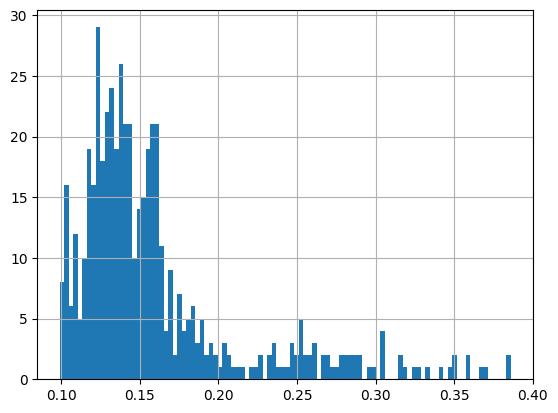

In [15]:
df['y_pred'].hist(bins=100)


<Axes: >

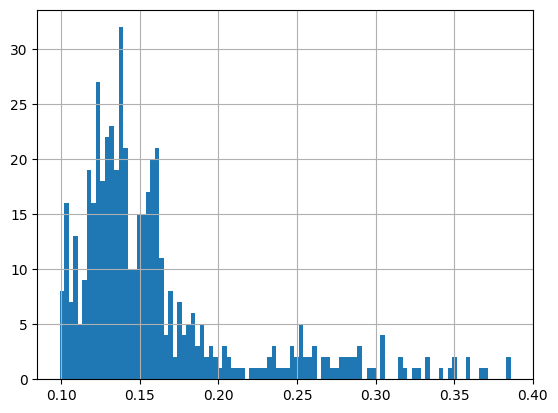

In [16]:
# df['SCORE'].hist(bins=100)
df[df['SCORE']!=1]['SCORE'].hist(bins=100)